In [31]:
### Computation

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import time
from sklearn import datasets
from PIL import Image

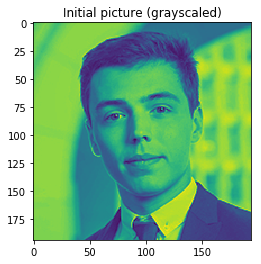

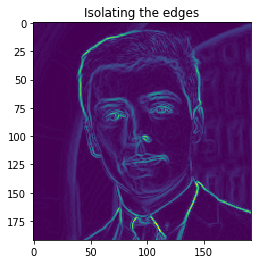

In [32]:
img = Image.open('18_pierre_monroy.jpg').convert('L')

arr = np.array(img)
plt.imshow(arr)
plt.title('Initial picture (grayscaled)')
plt.show()

sobol_x = np.asmatrix([[-1, 0, 1],
           [-2, 0, 2], 
           [-1, 0, 1]])

sobol_y = np.asmatrix([[1, 2, 1], 
           [0, 0, 0], 
           [-1,-2,-1]])

def sobolop(px_nb):

    x_p=np.sum(np.diag(np.dot(px_nb, sobol_x.T)))
    y_p=np.sum(np.diag(np.dot(px_nb, sobol_y.T)))

    val = np.ceil(np.sqrt(x_p**2 + y_p**2))
    
    return val

def img_apply(imag):

    height = imag.shape[0]
    width = imag.shape[1]

    if(len(imag.shape)>2):
        depth = imag.shape[2]
        res = np.zeros((height - 2, width - 2, depth))

        for z in range(depth):
            for i in range(1, height - 1):
                for j in range(1, width - 1):
                    res[i - 1, j - 1, z] = sobolop(np.asmatrix(imag[i - 1:i + 2, j - 1:j + 2, z]))
    else:
        res = np.zeros((height - 2, width - 2))
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                res[i - 1, j - 1] = sobolop(np.asmatrix(imag[i - 1:i + 2, j - 1:j + 2]))


    return res

test = img_apply(arr)

plt.imshow(test)
plt.title('Isolating the edges')
plt.show()

## Implementing the Otsu thresholding method

Otsu thresholding requires to compute the histogram of levels from the picture.
Then for each potential threshold level, we compute the Variance Between Class.
Finally the optimal threshold is the one maximizing the Variance Between Class.

This method is available in the package 'skimage'. However, the main objective was to implement it manually to get a better understanding of how it works.

In [33]:
def histoImage(im):

    unique, counts = np.unique(im, return_counts=True)
    dic = dict(zip(unique, counts))
    df = pd.DataFrame.from_dict(dic, orient='index')
    df = df.rename(index=int, columns={0: "histVals"})

    return df

def otsu_thresh(h, w, hist):

    hist['wB'] = hist['histVals'].cumsum()
    hist['wF'] = (hist['histVals'][::-1].cumsum())

    hist['Product'] = hist.histVals*hist.index
    hist['mB'] = hist['Product'].cumsum()/hist['wB']
    hist['mF'] = (hist['Product'][::-1].cumsum() / hist['wF'][::-1])[::-1]

    hist['VarBetw'] = hist['wB'].iloc[:-1]*hist['wF'].iloc[1:]*(hist['mB'].iloc[:-1] - hist['mF'].iloc[1:])**2
    t = np.argmax(hist['VarBetw'])

    return t

def otsu_thresh_wrapper(im):
    height = im.shape[0]
    width = im.shape[1]
    histo = dict()

    if(len(im.shape)> 2):
        depth = im.shape[2]
        im_thresh = np.zeros((height, width, depth))

        for z in range(depth):
            histo[z] = histoImage(im[:, :, z])
            thresh_opt = otsu_thresh(height, width, histo[z])
            im_thresh[:, :, z] = im[:, :, z] >= thresh_opt

    else:
        depth = 1
        im_thresh = np.zeros((height, width))
        histo = histoImage(im)
        thresh_opt = otsu_thresh(height, width, histo)
        im_thresh = im>= thresh_opt

    return im_thresh


### Running the Otsu thresholding method

In [34]:
tf_img = otsu_thresh_wrapper(test)
tf_img2 = otsu_thresh_wrapper(arr)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


### Comparison of the results of Otsu thresholding on a picture with edges isolated and without

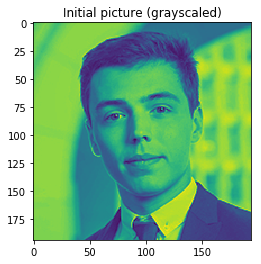

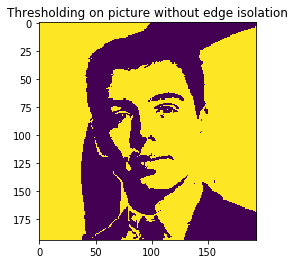

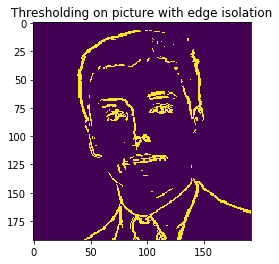

In [35]:
plt.imshow(arr)
plt.title('Initial picture (grayscaled)')
plt.show()

plt.imshow(tf_img2)
plt.title('Thresholding on picture without edge isolation')
plt.show()

plt.imshow(tf_img)
plt.title('Thresholding on picture with edge isolation')
plt.show()